In [1]:
using Pkg; Pkg.activate(".")
using CSV
using DataFrames
using PyPlot
using LaTeXStrings
using MUST
using DelimitedFiles
using Statistics
using Polynomials
MUST.@import_dispatch "../../../dispatch2"

  Activating environment at `/raven/ptmp/peitner/model_grids/MUST.jl/examples/running_dispatch/Project.toml`


PyObject <module 'dispatch' from '/raven/ptmp/peitner/model_grids/dispatch2/utilities/python/dispatch/__init__.py'>

In [2]:
results = DataFrame(CSV.File("summary_testrun1.csv"));

In [3]:
t, rho, ee0, ee_min, successP1, successP2 = eachcol(results[:,[:stellar_params!tt_k, :stellar_params!d_cgs, :newton_params!ee0, :stellar_params!ee_min, :phase1_success, :phase2_success]]);

# Phase 1 (no RT)

In [9]:
plt.close()
im = plt.scatter(t, rho, c=successP1, cmap="bwr_r")
plt.xlabel(L"\rm T_{ini}", fontsize="x-large")
plt.ylabel(L"\rm \rho_{ini}", fontsize="x-large")
cbar = plt.colorbar(im)
cbar.set_label("phase 1 (no RT)")
cbar.set_ticks([0,1])
cbar.set_ticklabels(["failed", "success"])
plt.savefig("t_rho_p1_success.png")

In [10]:
plt.close()
im = plt.scatter(ee0, ee_min, c=successP1, cmap="bwr_r")
plt.xlabel(L"\rm ee_{0}", fontsize="x-large")
plt.ylabel(L"\rm ee_{min}", fontsize="x-large")
cbar = plt.colorbar(im)
cbar.set_label("phase 1 (no RT)")
cbar.set_ticks([0,1])
cbar.set_ticklabels(["failed", "success"])
cbar.set_ticklabels(["failed", "success"])
plt.savefig("ee0_eemin_p1_success.png")

# Phase 2 (with RT)

In [11]:
plt.close()
im = plt.scatter(t, rho, c=successP2, cmap="bwr_r")
plt.xlabel(L"\rm T_{ini}", fontsize="x-large")
plt.ylabel(L"\rm \rho_{ini}", fontsize="x-large")
cbar = plt.colorbar(im)
cbar.set_label("phase 2 (no RT)")
cbar.set_ticks([0,1])
cbar.set_ticklabels(["failed", "success"])
plt.savefig("t_rho_p2_success.png")

In [17]:
plt.close()
im = plt.scatter(ee0, ee_min, c=successP2, cmap="bwr_r")
plt.xlabel(L"\rm ee_{0}", fontsize="x-large")
plt.ylabel(L"\rm ee_{min}", fontsize="x-large")
cbar = plt.colorbar(im)
cbar.set_label("phase 2 (no RT)")
cbar.set_ticks([0,1])
cbar.set_ticklabels(["failed", "success"])
plt.savefig("ee0_eemin_p2_success.png")

# Effective temperature of successful runs

In [12]:
get_teff(folder) = begin
    path = joinpath(folder, "teff.dat")
    if !ispath(path) @warn "$(path) does not exist."
        return nothing
    end
    data = readdlm(path)
end 

get_teff (generic function with 1 method)

In [13]:
folders = [@MUST.in_dispatch(joinpath("data",r[1:first(findfirst(".nml",r))-1])) for r in results[results.phase2_success .== true, :phase2_name]];

In [14]:
teff = [get_teff(f) for f in folders];

┌ Warning: /raven/ptmp/peitner/model_grids/dispatch2/experiments/stellar_atmospheres/data/grid4_phase2/teff.dat does not exist.
└ @ Main /ptmp/peitner/model_grids/MUST.jl/examples/running_dispatch/Valid_T_rho_comb.ipynb:3
┌ Warning: /raven/ptmp/peitner/model_grids/dispatch2/experiments/stellar_atmospheres/data/grid19_phase2/teff.dat does not exist.
└ @ Main /ptmp/peitner/model_grids/MUST.jl/examples/running_dispatch/Valid_T_rho_comb.ipynb:3


┌ Warning: /raven/ptmp/peitner/model_grids/dispatch2/experiments/stellar_atmospheres/data/grid32_phase2/teff.dat does not exist.
└ @ Main /ptmp/peitner/model_grids/MUST.jl/examples/running_dispatch/Valid_T_rho_comb.ipynb:3
┌ Warning: /raven/ptmp/peitner/model_grids/dispatch2/experiments/stellar_atmospheres/data/grid51_phase2/teff.dat does not exist.
└ @ Main /ptmp/peitner/model_grids/MUST.jl/examples/running_dispatch/Valid_T_rho_comb.ipynb:3


In [16]:
plt.close()
for r in teff
    isnothing(r) && continue
    
    plt.plot(r[:,1], r[:,2], marker=".")
end
plt.ylim(4500,5750)
plt.savefig("teff.png")

In [18]:
teff_t = Float64[]
for t in teff
    try
        isnothing(t) ? append!(teff_t, [NaN]) : append!(teff_t, [mean(t[end-20:end,2])])
    catch
        append!(teff_t, [NaN])
    end
end

In [19]:
t_success, rho_success = eachcol(results[results.phase2_success .== true, [:stellar_params!tt_k, :stellar_params!d_cgs]]);

In [20]:
plt.close()
im = plt.scatter(t_success, rho_success, c=teff_t, cmap="gnuplot", s=50)
cbar = plt.colorbar(im)
plt.xlabel(L"\rm T_{ini}", fontsize="x-large")
plt.ylabel(L"\rm \rho_{ini}", fontsize="x-large")
cbar.set_label(L"\rm T_{eff}", fontsize="x-large")
plt.savefig("t_rho_teff.png")

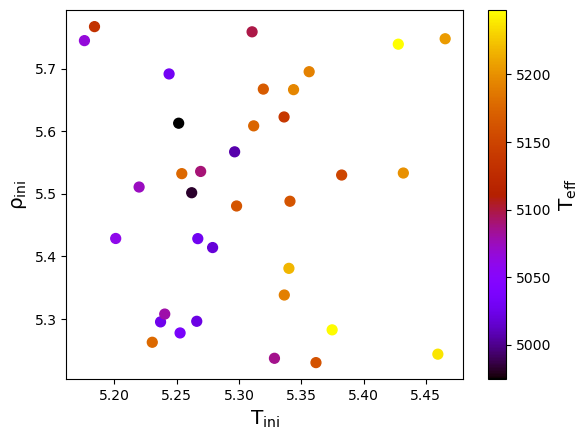

In [15]:
im = plt.scatter(ee0_success, ee_min_success, c=teff_t, cmap="gnuplot", s=50)
cbar = plt.colorbar(im)
plt.xlabel(L"\rm T_{ini}", fontsize="x-large")
plt.ylabel(L"\rm \rho_{ini}", fontsize="x-large")
cbar.set_label(L"\rm T_{eff}", fontsize="x-large")

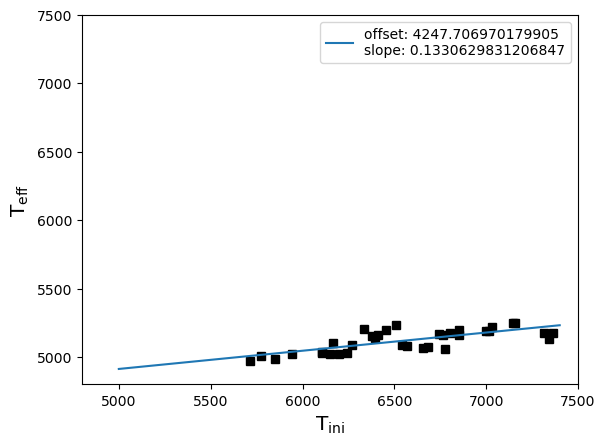

PyObject <matplotlib.legend.Legend object at 0x2b002b0cc100>

In [16]:
plt.plot(t_success, teff_t, marker="s", ls="", color="k")
plt.xlabel(L"\rm T_{ini}", fontsize="x-large")
plt.ylabel(L"\rm T_{eff}", fontsize="x-large")

mask = .!isnan.(teff_t)
linfit = Polynomials.fit(t_success[mask], teff_t[mask], 1)
x = [5000:100:7400...]; y = linfit.coeffs[1] .+ linfit.coeffs[2] .* x 
plt.plot(x, y, label="offset: $(linfit.coeffs[1])\nslope: $(linfit.coeffs[2])")

plt.xlim(4800,7500)
plt.ylim(4800,7500)

plt.legend()

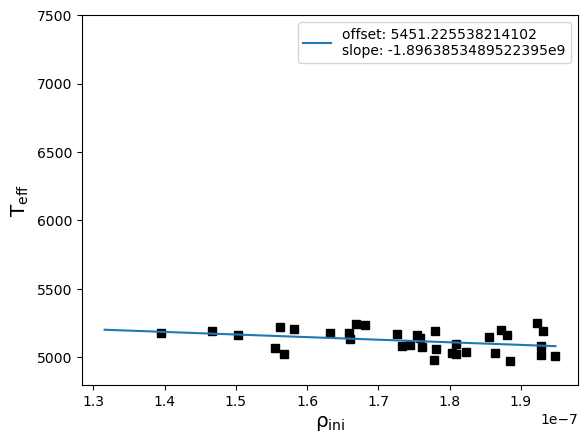

PyObject <matplotlib.legend.Legend object at 0x2b002dcfaa00>

In [32]:
plt.plot(rho_success, teff_t, marker="s", ls="", color="k")

mask = .!isnan.(teff_t)
linfit_rho = Polynomials.fit(rho_success[mask], teff_t[mask], 1)
x2 = [range(minimum(rho_success),maximum(rho_success),length=100)...]
y2 = linfit_rho.coeffs[1] .+ linfit_rho.coeffs[2] .* x2
plt.plot(x2, y2, label="offset: $(linfit_rho.coeffs[1])\nslope: $(linfit_rho.coeffs[2])")

plt.xlabel(L"\rm \rho_{ini}", fontsize="x-large")
plt.ylabel(L"\rm T_{eff}", fontsize="x-large")
plt.ylim(4800,7500)
plt.legend()

No handles with labels found to put in legend.


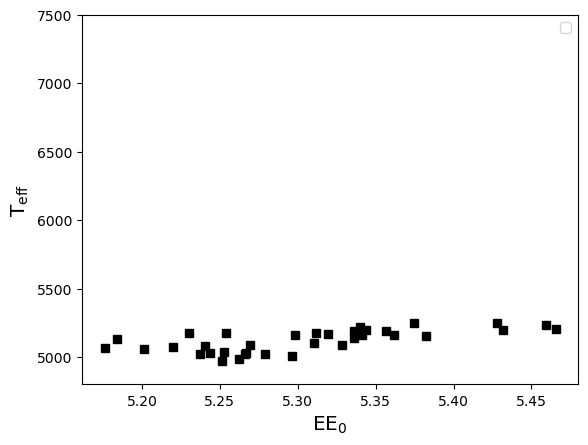

PyObject <matplotlib.legend.Legend object at 0x2b002b2015b0>

In [34]:
plt.plot(ee0_success, teff_t, marker="s", ls="", color="k")

plt.xlabel(L"\rm EE_{0}", fontsize="x-large")
plt.ylabel(L"\rm T_{eff}", fontsize="x-large")
plt.ylim(4800,7500)
plt.legend()

No handles with labels found to put in legend.


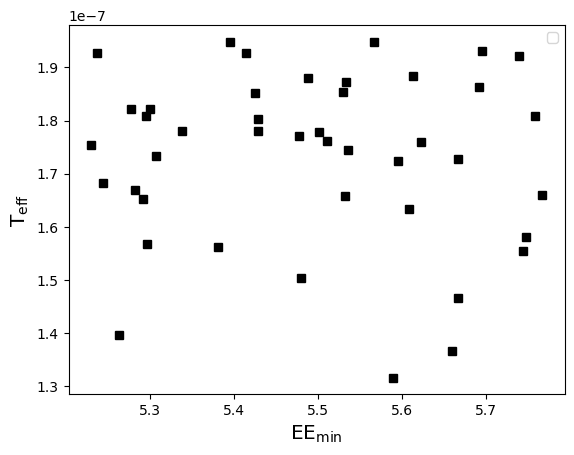

PyObject <matplotlib.legend.Legend object at 0x2b002dea10a0>

In [40]:
plt.plot(ee_min_success, rho_success, marker="s", ls="", color="k")

plt.xlabel(L"\rm EE_{min}", fontsize="x-large")
plt.ylabel(L"\rm T_{eff}", fontsize="x-large")
#plt.ylim(4800,7500)
plt.legend()

In [69]:
function get_initial(t_success, rho_success, teff; goal=5778.0)
    mask = .!isnan.(teff)
    linfit_t   = Polynomials.fit(t_success[mask], teff[mask], 1)
    linfit_rho = Polynomials.fit(t_success, log.(rho_success), 1)
    
    t_ini = (goal - linfit_t.coeffs[1])/linfit_t.coeffs[2]

    (t_ini, exp(linfit_rho.coeffs[1] + linfit_rho.coeffs[2]*t_ini))
end

get_initial (generic function with 1 method)

In [70]:
get_initial(t_success, rho_success, teff_t)

(11500.51647671358, 1.481205255825645e-7)

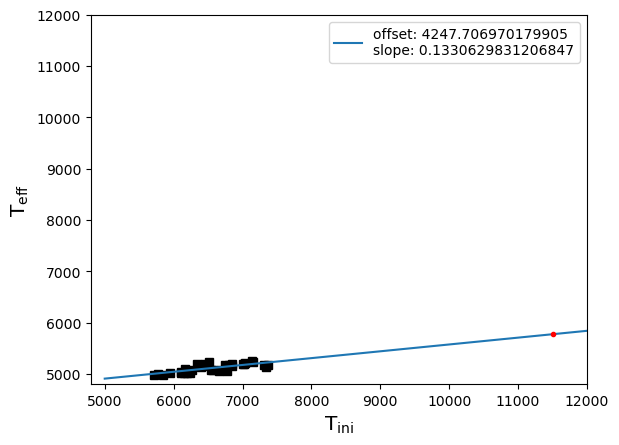

PyObject <matplotlib.legend.Legend object at 0x2b002e2cae80>

In [58]:
plt.plot(t_success, teff_t, marker="s", ls="", color="k")
plt.xlabel(L"\rm T_{ini}", fontsize="x-large")
plt.ylabel(L"\rm T_{eff}", fontsize="x-large")

mask = .!isnan.(teff_t)
linfit = Polynomials.fit(t_success[mask], teff_t[mask], 1)
x = [5000:100:12000...]; y = linfit.coeffs[1] .+ linfit.coeffs[2] .* x 
plt.plot(x, y, label="offset: $(linfit.coeffs[1])\nslope: $(linfit.coeffs[2])")

plt.xlim(4800,12000)
plt.ylim(4800,12000)

plt.plot([11500.51647671358],[5778], color="red", marker=".")

plt.legend()

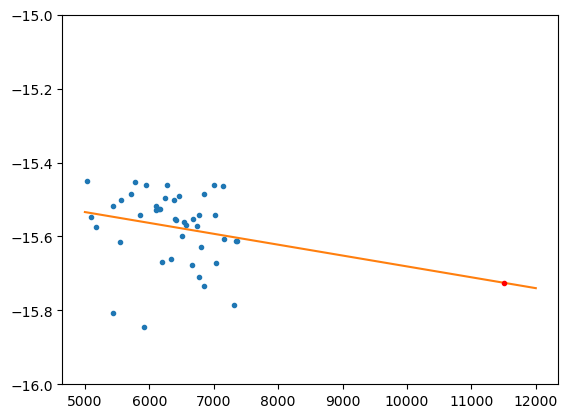

(-16.0, -15.0)

In [72]:
plt.plot(t_success, log.(rho_success), marker=".", ls="")


linfit = Polynomials.fit(t_success, log.(rho_success), 1)
x = [5000:100:12000...]; y = linfit.coeffs[1] .+ linfit.coeffs[2] .* x 
plt.plot(x, y, label="offset: $(linfit.coeffs[1])\nslope: $(linfit.coeffs[2])")

plt.plot([11500.51647671358],log.([1.481205255825645e-7]), marker=".", color="red")

plt.ylim(-16,-15)